In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

# from utils.Auger.SD import Monitoring

from scipy.optimize import curve_fit
from utils.binaries import *
from utils.plotting import *

10:44:24 [INFO] utils          -- (+27130ms) -- import logging
10:44:24 [INFO] utils.binaries -- (    +1ms) -- import numpy as np
10:44:24 [INFO] utils.binaries -- (    +6ms) -- import uncertainties
10:44:24 [INFO] utils.binaries -- (    +1ms) -- import numpy as np
10:44:24 [INFO] utils.binaries -- (    +6ms) -- import uncertainties
10:44:25 [INFO] utils.binaries -- (  +170ms) -- import pandas as pd
10:44:25 [INFO] utils.binaries -- (    +1ms) -- import binaries.tools as tools
10:44:25 [INFO] utils.plotting -- (  +480ms) -- import matplotlib.pyplot as plt
10:44:25 [INFO] utils.plotting -- (  +158ms) -- import seaborn as so
10:44:25 [DBUG] utils.plotting -- (   +12ms) -- font size set to 9.5
10:44:25 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
10:44:25 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
10:44:25 [DBUG] utils.plotting -- (    +0ms) -- markersize set to 2.0
10:44:25 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
10:44:25 [INF

In [3]:
def parabola(x, a, b, c):
    return a * x**2 + b*x + c

def make_histo(counts, skip_to_threshold = 12):
    
    # see Station.h in Framework/SDetector
    ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])
    ADC_width = np.diff(ADC_bin_edges)    
    histo = []

    for i, count in enumerate(counts[skip_to_threshold:]):
        idx = i + skip_to_threshold
        width = ADC_width[idx]
        wiggle = np.random.uniform(-0.5*width, 0.5*width, int(count))
        array = np.array([ADC[idx] for _ in range(int(count))])
        histo += [w + a for w, a in zip(wiggle, array)]

    return histo

def make_histo_fit(histogram):
    binned, edges = np.histogram(histogram, bins=1000)
    position_of_peak = np.argmax(binned)
    start, stop = max(0, position_of_peak - 20), position_of_peak + 50
    x_fit = 0.5 * (edges[1:] + edges[:-1])

    try:
        (a, b, c), pp = curve_fit(parabola, x_fit[start:stop], np.log(binned)[start:stop], 
                            bounds=[[-np.inf, 0, 0],[0, np.inf, np.inf]],
                            p0=[-1000, 1, 1e3],
                            check_finite=True)
    
        (a, b, c) = uncertainties.correlated_values((a, b, c), pp)

    except ValueError:
        a, b, c = np.nan, np.nan, np.nan

    # if -b/(2*a) is np.nan:
    #     plt.figure()
    #     plt.plot(x_fit, np.exp(parabola(x_fit, a, b, _)), label='lstsq. fit')
    #     plt.plot(x_fit, binned, label='SSD histo')
    #     plt.axvline(x_fit[start], ls='--')
    #     plt.axvline(x_fit[stop], ls='--')
    #     plt.yscale('log')
    #     plt.legend()
    #     plt.savefig(f'/cr/users/filip/plots/failed_{_id}_{time}.png')

    return -b/(2*a) if 10 < -b/(2*a) < 250 else np.nan

10:47:05 [DBUG] utils.plotting -- (+17124ms) -- font size set to 9.5
10:47:05 [DBUG] utils.plotting -- (    +2ms) -- label size set to 13.0
10:47:05 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [3.3, 2.5]
10:47:05 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
10:47:05 [DBUG] utils.plotting -- (    +1ms) -- usetex set to True


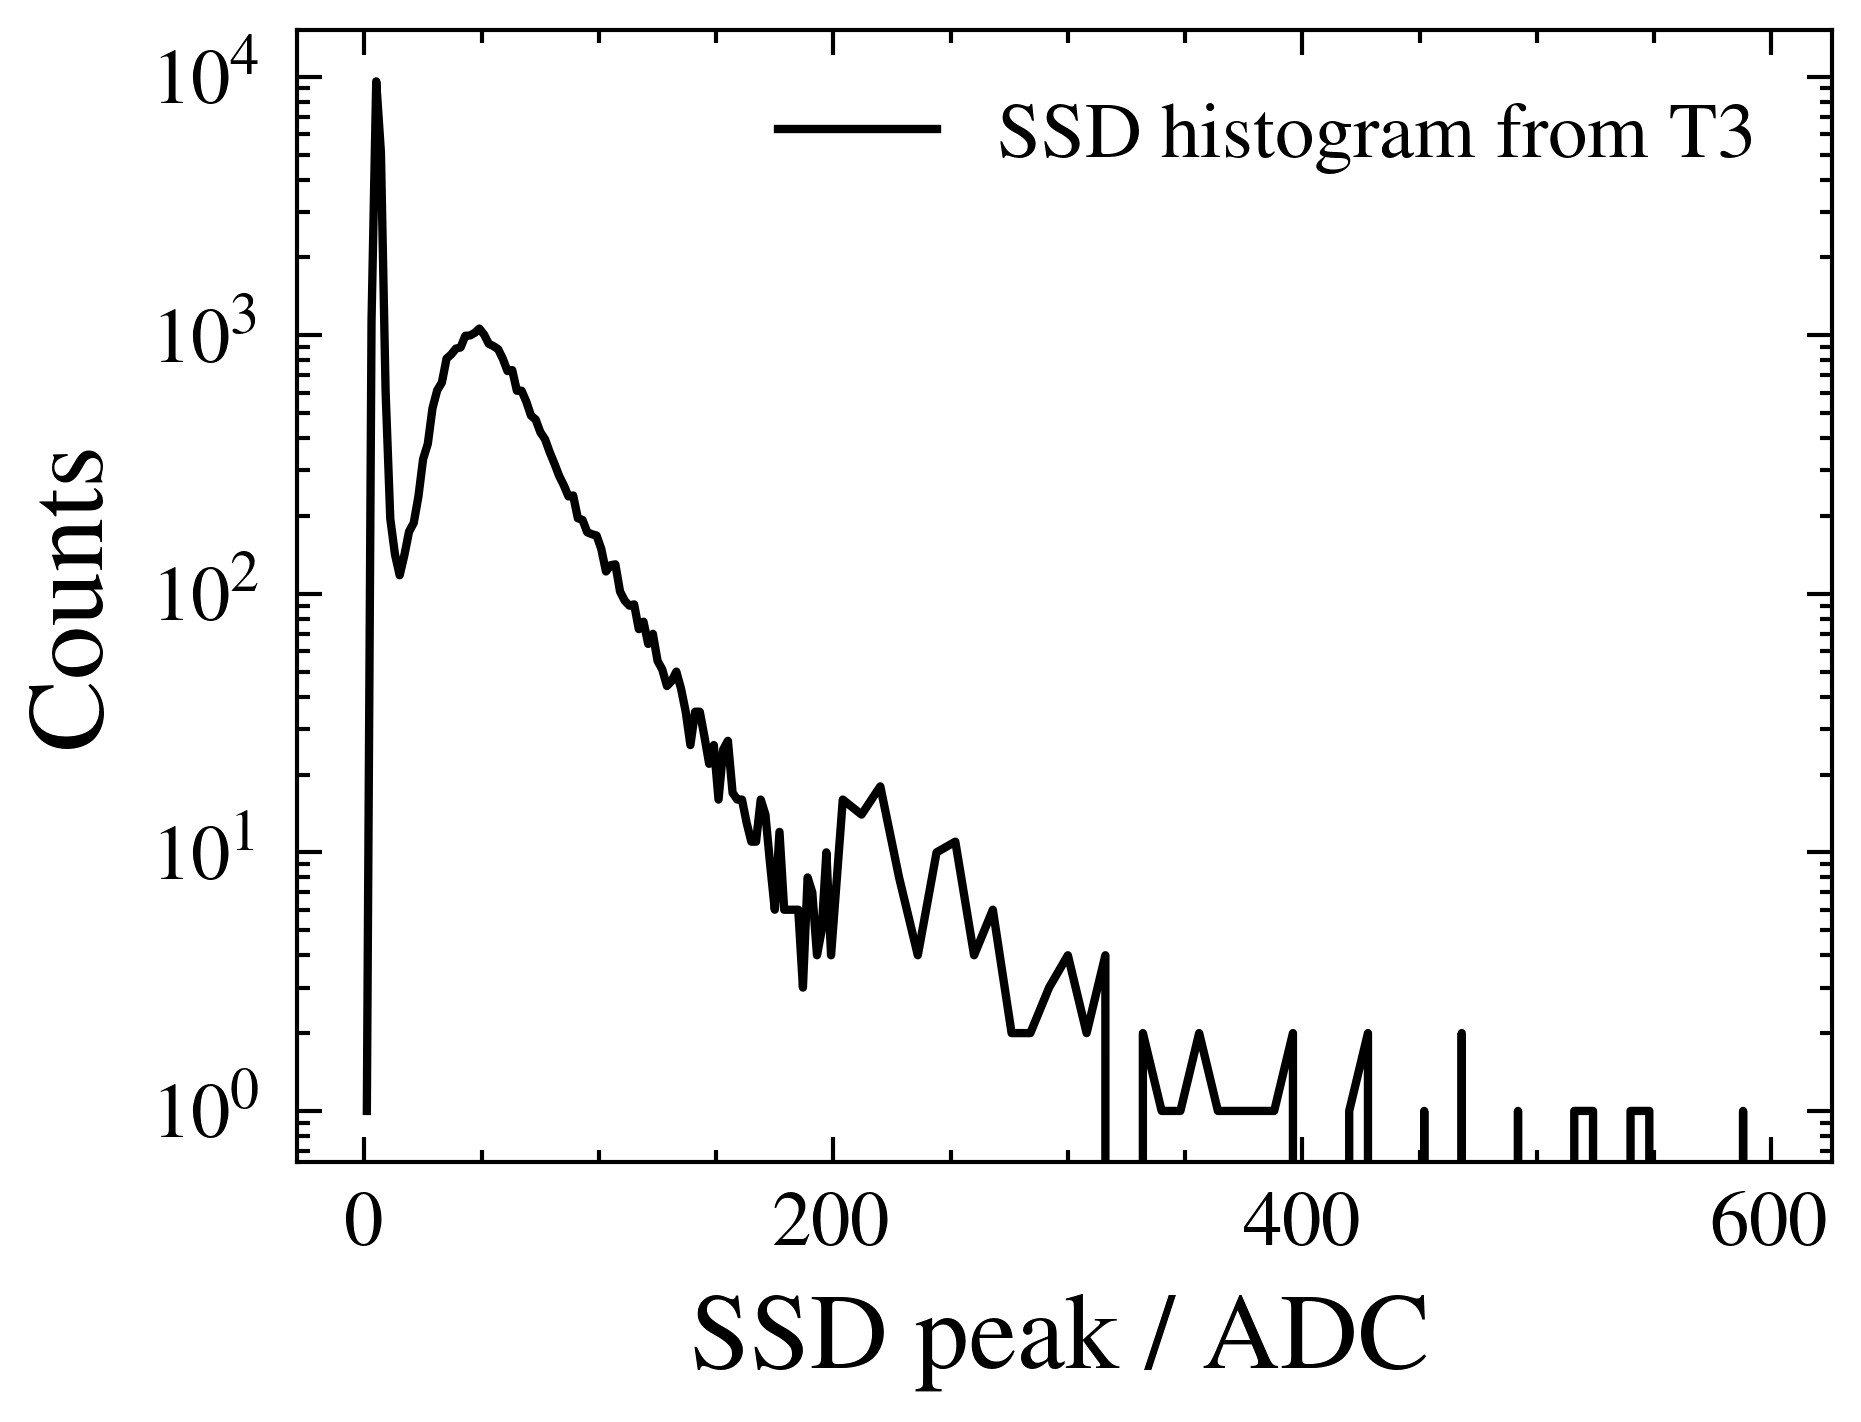

In [4]:
set_plt_style('double tex')

ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])

with open('/cr/users/filip/Data/SDMonitHistos/all.txt', 'r') as infile:
    while True:

        event = infile.readline()

        ID, timestamp, *histo = [int(x) for x in event.split()]
        # print(ID, end='\r')

        # histo_resampled = make_histo(histo)
        # mip = make_histo_fit(histo_resampled)
        # mip, dmip = mip.n, mip.std_dev

        # (a, b, c), pp = curve_fit(parabola, ADC[12:40], np.log(histo[12:40]), 
        #                 bounds=[[-np.inf, 0, 0],[0, np.inf, np.inf]],
        #                 p0=[-1000, 1, 1e3],
        #                 check_finite=True)
        
        # if dmip > 100 or int(-b/(2*a)) != int(mip): continue

        plt.plot(ADC, histo, label='SSD histogram from T3')
        # plt.hist(histo_resampled, histtype='step', bins=1000, lw=0.3, label='histogram resampled')
        # plt.axvline(mip, c='r', ls='--', label=f"$I^\mathrm{{SSD}}_\mathrm{{histo}} = {mip:.2f}({1e2*dmip:.0f})\,\mathrm{{ADC}}$", lw=0.6)
        # plt.axvline(-b/(2*a), c='k', ls=':', label=f"$I^\mathrm{{SSD}}_\mathrm{{histo}} = {-b/(2*a):.2f}(31)\,\mathrm{{ADC}}$", lw=0.6)
        plt.ylabel('Counts')
        plt.xlabel('SSD peak / ADC')
        plt.yscale('log')
        plt.legend()

        break

plt.savefig('/cr/users/filip/plots/UubRandoms/histograms/T3_example')